In [150]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
from sklearn.linear_model import LinearRegression
from tqdm import tqdm


In [151]:
def create_spatial_grid_torch(stim, stim_ecc, gridsize):
    coord = np.sqrt(((stim_ecc)**2)/2)
    grid = torch.linspace(-coord,coord,gridsize)
    Y,X = torch.meshgrid(grid, grid)
    Y = -1*Y
    (s1, s2) = (stim.shape[0] // X.shape[0]+1, stim.shape[1] // X.shape[0]+1)
    input_stim = stim[::s1,::s2]
    return input_stim, X, Y

In [152]:
def flat_gaussian_field_torch(X,Y,x,y,sigma,gain,normalize):
    gaussian = gain*(torch.exp(-((X-x)**2 +(Y-y)**2)/(2*sigma)**2))
    if normalize: # this normalizes the Gaussian field to the unit volume before flattening it
        gaussian = gaussian/torch.sum(gaussian)
    return gaussian.flatten()

In [153]:
def create_prf_params(n_voxels, stim_ecc, X, Y):  
    coord = np.sqrt(((stim_ecc)**2)/2)
    nCenters = int(np.sqrt(n_voxels))
    x = -1*np.linspace(-coord, coord, nCenters)
    y = np.linspace(-coord, coord, nCenters)
    prf_parameters = np.zeros((4,n_voxels))
    sigma = np.zeros((n_voxels))
    gain = np.zeros((n_voxels))

    iter_idx = 0
    for i in range(0,len(x)):
        for j in range(0,len(y)):
            prf_parameters[0,iter_idx] = x[i] 
            prf_parameters[1,iter_idx] = y[j]
            prf_parameters[2,iter_idx] = 0.05 + 0.2*(np.sqrt(x[i]**2 +  y[j]**2)) # sigma
            prf_parameters[3,iter_idx] = 1 # assume uniform voxel gain for simplicity
            iter_idx = iter_idx + 1 

    return prf_parameters

In [160]:
class AttModel(torch.nn.Module):
    def __init__(self,  prf_parameters, n_voxels=4096, gridsize=64, stim_ecc=12, attention_ctr=(0,8)):
        """
        """
        super().__init__()
        self.simulated_prfs = prf_parameters
        self.attention_ctr = attention_ctr
        self.n_voxels = n_voxels
        coord = np.sqrt(((stim_ecc)**2)/2)
        grid = torch.linspace(-coord, coord, gridsize)
        self.Y, self.X = torch.meshgrid(grid, grid)
        self.Y = -1* self.Y

        self.voxel_gain = torch.nn.Parameter(torch.rand(1, n_voxels, dtype=torch.float32))
        self.attention_sigma = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.attention_gain = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.suppression_sigma_scale_factor = torch.nn.Parameter(torch.rand(1, n_voxels, dtype=torch.float32))
        self.summation_sigma_scale_factor = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        self.normalization_sigma_factor = torch.nn.Parameter(torch.rand(1, dtype=torch.float32))
        
    def forward(self, stim):
        """
        """

        stimdrive = torch.empty(self.n_voxels)
        numerator = torch.empty(self.n_voxels)
        surroundresponse = torch.empty(self.n_voxels)
        spsummedresponse = torch.empty(self.n_voxels)
        
        for rf in range(self.n_voxels):
            RF = flat_gaussian_field_torch(self.X, self.Y, self.simulated_prfs[1,rf], self.simulated_prfs[0,rf],
                                           self.simulated_prfs[2,rf], self.voxel_gain[:,rf], True)
            stim = stim.flatten()
            stimdrive[rf] = torch.dot(RF, stim)
            attweight = torch.exp(-((self.attention_ctr[0]-self.simulated_prfs[1,rf])**2
                                     + (self.attention_ctr[1]-self.simulated_prfs[0,rf])**2)/(2*self.attention_sigma)**2)
            attweight =  self.attention_gain*attweight+1
            numerator[rf] = torch.multiply(stimdrive[rf],attweight)
        
        for rfsupp in range(self.n_voxels):
            distance = torch.sqrt((self.X-self.simulated_prfs[1, rfsupp])**2
                                  + (self.Y-self.simulated_prfs[0,rfsupp])**2)
            suppfield = torch.exp(-.5*(distance/(self.simulated_prfs[2,rfsupp]*self.suppression_sigma_scale_factor[:,rfsupp]))**2)
            suppfield = suppfield / torch.sum(suppfield)
            flatsurr = suppfield.flatten()
            surroundresponse[rfsupp] = torch.dot(flatsurr,numerator)
            
        predneuralweights = numerator/(surroundresponse + self.normalization_sigma_factor)

        for rfsumm in range(self.n_voxels):
            distance = torch.sqrt((self.X-self.simulated_prfs[1,rfsumm])**2
                                  +(self.Y-self.simulated_prfs[0,rfsumm])**2);
            summfield = torch.exp(-.5*(distance/(self.simulated_prfs[2,rfsumm]*self.summation_sigma_scale_factor))**2)
            summfield = summfield / torch.sum(summfield)
            flatsumm = summfield.flatten()
            spsummedresponse[rfsumm] = torch.dot(flatsumm,predneuralweights)
    
        return stimdrive, numerator, predneuralweights, spsummedresponse

In [171]:
stimpath = '/Volumes/server/Projects/attentionpRF/Simulations/python_scripts/stimfiles'
stim_ecc = 12
stimtemp = scipy.io.loadmat(stimpath + '/stim.mat')
stimtemp = torch.from_numpy(stimtemp['stim']).to(torch.float32)
stimorig = stimtemp[:,:,36]
#stimorig = stimorig[::1080//64, ::1080//64]
#stimorig = stimorig[:64, :64]
input_stim, X, Y = create_spatial_grid_torch(stimorig, stim_ecc, 64)
prf_parameters = create_prf_params(input_stim.shape[0]*input_stim.shape[0], stim_ecc, X, Y)

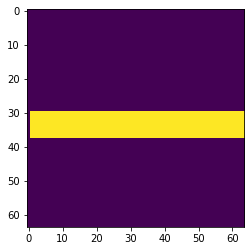

In [172]:
plt.imshow(input_stim)

In [173]:
nma = AttModel(prf_parameters)
stimdrive, numerator, neuralresponse, populationresponse = nma(input_stim)

In [174]:
stimdrive = stimdrive.detach().numpy()
numerator = numerator.detach().numpy()
populationresponse = populationresponse.detach().numpy()
neuralresponse = neuralresponse.detach().numpy()

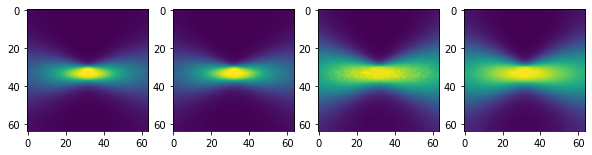

In [175]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=[10,10])
ax1.imshow(np.reshape(stimdrive,(64,64)))
ax2.imshow(np.reshape(numerator,(64,64)))
ax3.imshow(np.reshape(neuralresponse,(64,64)))
ax4.imshow(np.reshape(populationresponse,(64,64)))

Now define the objective function to optimize the beta weights predicted by normalization model. It *feels* like it will do it over all the voxels.

In [125]:
def obj_function(measured_response, predicted_nma_response):
    model = LinearRegression()
    model.fit(predicted_nma_response, measured_response)
    prediction = model.predict(predicted_nma_response)
    residualsumsq = torch.sum(torch.square(prediction-predicted_nma_response))
    return residualsumsq

In [126]:
optimizer = torch.optim.Adam([nma.voxel_gain, # estimated per voxel
                              nma.attention_sigma, # estimated for the ROI (?) as in, across all voxels
                              nma.attention_gain, # 1 estimate
                              nma.suppression_sigma_scale_factor, # estimated per voxel? not sure if we will change
                              nma.summation_sigma_scale_factor, # estimated per ROI
                              nma.normalization_sigma_factor], # probably estimated per ROI
                              lr=1e-3)

In [127]:
# use the fitted RFs for now to recover the parameters
simulateddatapath = '/Volumes/server/Projects/attentionpRF/Simulations/simulatedData'
stimdrivenrfs = scipy.io.loadmat(simulateddatapath + '/fittedRFs_subset.mat')
neutralRFs = torch.from_numpy(stimdrivenrfs['RF_subset']).to(torch.float32)
# load the attention data for these RFs:
simulateddatapath = '/Volumes/server/Projects/attentionpRF/Simulations/matlab_scripts/fitData'
simulatedbetaweights = scipy.io.loadmat(simulateddatapath + '/simulateddata_subset.mat')
simulatedbetaweights = torch.from_numpy(simulatedbetaweights['datatofit_subset']).to(torch.float32)

In [ ]:
losses = []
parameters = []
pbar = tqdm(range(1000))
for i in pbar
    predicted_nma_response =
